# Digital Earth Africa Demo - Water Body Surface Extents

This notebook gives an example of using DEAfrica water classification products to identify water bodies 
and map their extents over time.

Following steps are demonstrated:
1. [Load water summaries and identify the largest water body](#water_summary) 
4. [Load water classification time series and visualize](#water_series)
5. [Plot extent vs time for the water body identified above](#extents)



## 1. Load water summaries and identify the largest water body <a name="water_summary"></a>

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import xarray as xr

import datacube
from datacube.storage import masking

In [2]:
dc = datacube.Datacube(app='water_demo')

In [3]:
# define area
lat = (-4.75, -4.65)
lon = (34.8, 34.9)
crs = 'EPSG:32636'

In [4]:
# list measurements available for water summary
dc.list_measurements().loc[('ls_usgs_wofs_summary')]

,aliases,dtype,flags_definition,name,nodata,units
measurement,,,,,,
count_wet,[wet],int16,NaN,count_wet,-999,1
count_dry,[dry],int16,NaN,count_dry,-999,1
frequency,[freq],float32,NaN,frequency,NaN,1


In [5]:
# load water summary
water_summary = dc.load(product = 'ls_usgs_wofs_summary', 
                        # Location can be defined in Lat/Lon or X/Y and a projection.
                        lat = lat, lon = lon,
                        # Define output specifications; default interploation in reprojection is 'nearest'
                        output_crs = crs,
                        resolution = (-30, 30),
                        # only load frequency,
                        measurements = ['frequency']
                        )

In [6]:
# select the year with larget water extent
water_frac = (water_summary.frequency>0).groupby('time').mean(dim = xr.ALL_DIMS).values
max_year = water_summary.isel(time = (water_frac == water_frac.max())).squeeze()

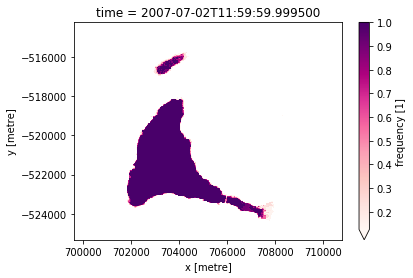

In [7]:
max_year.where(max_year>0).frequency.plot.imshow(robust=True, cmap='RdPu');

In [8]:
from rasterio import features
from shapely.geometry import shape

def find_largest_water_body(water_mask):
    max_water = 0
    for fshape, value in features.shapes((water_mask).values.astype('int16'), mask=(water_mask).values):
        geom=shape(fshape)
        if geom.area>max_water:
            max_water = geom.area
            water_body = geom
    return water_body

water_body = find_largest_water_body(max_year.frequency>0)

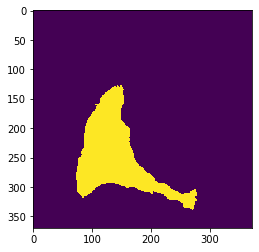

In [9]:
water_body_mask = features.rasterize([(water_body,1)], out_shape=(len(max_year.y), len(max_year.x)), fill=0, 
                   transform=(1, 0.0, 0.0, 0.0, 1, 0), all_touched=True)
plt.imshow(water_body_mask, vmin=0, vmax=1);

## 2. Load water classification time series and visualize <a name="water_series"></a>

In [10]:
wofs_series = dc.load(product = 'ls_usgs_wofs_scene', 
                     # Location can be defined in Lat/Lon or X/Y and a projection.
                     lat = lat, lon=lon,
                     # Constrain the time period
                     time = ('2015-01-01', '2019-01-01'),
                     # Define output specifications; default interploation in reprojection is 'nearest'
                     output_crs = crs,
                     resolution = (-30, 30),
                    )

In [11]:
# mask cloud and shadow
mask = masking.make_mask(wofs_series.water, cloud=False, cloud_shadow=False, nodata=False)
clear_frac = mask.where(water_body_mask).groupby('time').mean(dim=xr.ALL_DIMS).values
good = clear_frac > 0.8

In [12]:
# extract water classifications for clear dates
water = masking.make_mask(wofs_series.isel(time=good).water, water_observed=True).where(mask.isel(time=good))
water = water.where(water_body_mask)

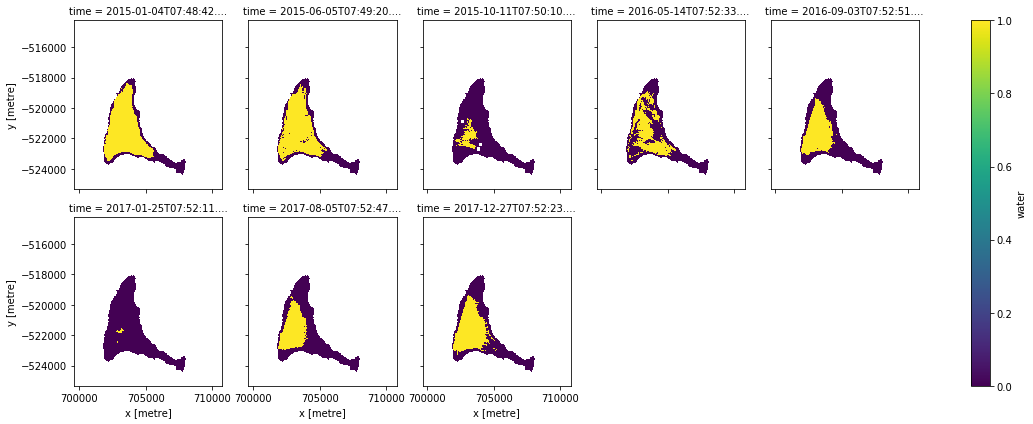

In [13]:
# plot a few dates
water.isel(time=slice(0,len(water.time),10)).plot.imshow(robust=True, col='time',col_wrap=5);

## 3. Plot extent vs time for the water body identified above <a name="extents"></a>

In [14]:
fill_frac = water.groupby('time').mean(dim=xr.ALL_DIMS)

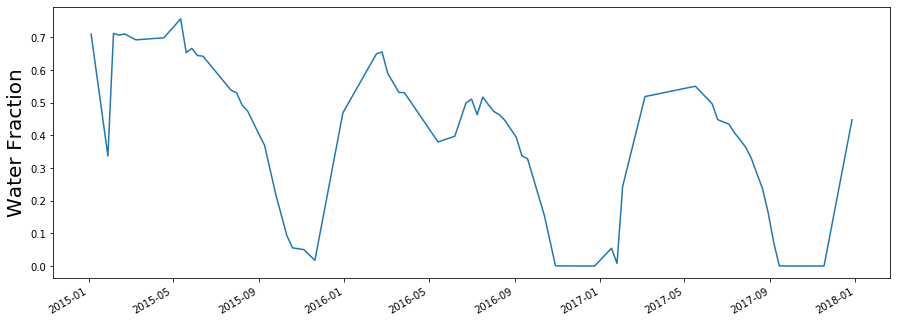

In [15]:
fill_frac.plot.line(figsize=(15,5)); 
plt.xlabel('');
plt.ylabel('Water Fraction', fontsize=20);